# 03 – Model Selection with Cost-Weighted Service Loss (CWSL)

In this notebook we show how to use **CWSL as the model selection criterion**.

Instead of picking the "best" model by RMSE or MAPE, we:

1. Define multiple candidate forecast models.
2. Evaluate them using **CWSL**, given asymmetric costs (`cu`, `co`).
3. Use `select_model_by_cwsl` to pick the model that **minimizes CWSL**.

For simplicity, we'll use tiny toy models that always return fixed prediction
patterns. This keeps the focus on the **selection logic** instead of model
complexity.

In [8]:
import numpy as np
import pandas as pd

from cwsl import cwsl, select_model_by_cwsl

In [9]:
# A simple "day" of demand: morning → peak → evening
y_val = np.array([10, 12, 15, 20, 25, 22, 18, 14, 10], dtype=float)
y_val

array([10., 12., 15., 20., 25., 22., 18., 14., 10.])

In [10]:
class FixedPredictor:
    """
    Tiny estimator-like class for demonstration.

    - fit(X, y) does nothing and returns self
    - predict(X) returns a fixed vector, ignoring X
    """
    def __init__(self, y_pred_val, name=None):
        self.y_pred_val = np.asarray(y_pred_val, dtype=float)
        self.name = name or "fixed"

    def fit(self, X, y):
        # No-op fit; just return self
        return self

    def predict(self, X):
        n = len(X)
        if n != len(self.y_pred_val):
            raise ValueError(
                f"Length of X ({n}) does not match stored predictions "
                f"({len(self.y_pred_val)})."
            )
        return self.y_pred_val

In [11]:
# Perfect forecast: ideal but often unrealistic
y_pred_neutral = y_val.copy()

# Under-leaning forecast: always 2 units too low
y_pred_under = y_val - 2.0

# Over-leaning forecast: always 2 units too high
y_pred_over = y_val + 2.0

y_pred_neutral, y_pred_under, y_pred_over

(array([10., 12., 15., 20., 25., 22., 18., 14., 10.]),
 array([ 8., 10., 13., 18., 23., 20., 16., 12.,  8.]),
 array([12., 14., 17., 22., 27., 24., 20., 16., 12.]))

In [12]:
# Dummy "features" – not actually used by FixedPredictor
X_val = np.zeros((len(y_val), 1))
X_train = np.zeros((5, 1))
y_train = np.zeros(5)

models = {
    "neutral": FixedPredictor(y_pred_neutral, name="neutral"),
    "under_lean": FixedPredictor(y_pred_under, name="under_lean"),
    "over_lean": FixedPredictor(y_pred_over, name="over_lean"),
}

models

{'neutral': <__main__.FixedPredictor at 0x23a37e36270>,
 'under_lean': <__main__.FixedPredictor at 0x23a37ea96d0>,
 'over_lean': <__main__.FixedPredictor at 0x23a37ea9810>}

In [13]:
cu = 2.0  # shortfall cost
co = 1.0  # overbuild cost

rows = []
for name, model in models.items():
    y_pred = model.predict(X_val)
    score = cwsl(y_true=y_val, y_pred=y_pred, cu=cu, co=co)
    rows.append({"model": name, "CWSL": score})

manual_df = pd.DataFrame(rows).set_index("model")
manual_df

,CWSL
model,
neutral,0.000000
under_lean,0.246575
over_lean,0.123288


In [14]:
best_name, best_model, results = select_model_by_cwsl(
    models=models,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    cu=cu,
    co=co,
)

results

,CWSL,RMSE,wMAPE
model,,,
neutral,0.000000,0.0,0.000000
under_lean,0.246575,2.0,0.123288
over_lean,0.123288,2.0,0.123288


In [15]:
best_name, best_model

('neutral', <__main__.FixedPredictor at 0x23a37e36270>)

In [16]:
results.loc[["under_lean", "over_lean"]]

,CWSL,RMSE,wMAPE
model,,,
under_lean,0.246575,2.0,0.123288
over_lean,0.123288,2.0,0.123288


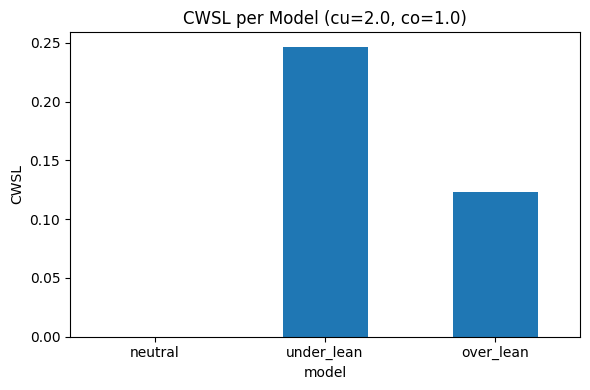

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
results["CWSL"].plot(kind="bar")

plt.title("CWSL per Model (cu=2.0, co=1.0)")
plt.ylabel("CWSL")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Conclusion

In this toy example:

- The **neutral** model is perfect and has CWSL ≈ 0.
- The **under-lean** and **over-lean** models have the same symmetric error
  (they are always 2 units away from the truth), so **RMSE cannot distinguish
  which direction is operationally worse**.
- With CWSL and `cu=2.0`, `co=1.0`:
  - Under-forecasting is penalized twice as heavily as over-forecasting.
  - The **under-lean** model has strictly higher CWSL than the **over-lean**
    model, even though their RMSE is identical.

Using `select_model_by_cwsl`:

- We train/evaluate all candidate models (here, tiny toy predictors),
- Compute **CWSL, RMSE, and wMAPE** on the same validation set,
- And choose the model that **minimizes CWSL**, i.e. the one that is best
  aligned with our asymmetric cost structure.

In real-world settings, you would replace these toy models with actual
regressors (RandomForest, GradientBoosting, LightGBM, etc.), but the decision
rule is the same:

> Train your models however you like, but let **CWSL** decide which one is
> operationally best under your cost asymmetry.